# DETEKSI EMOSI DARI TEXT MENGGUNAKAN LSTM  

# Dataset merupakan data publik, diambil dari [link](https://www.kaggle.com/datasets/parulpandey/emotion-dataset), dengan sedikit perubahan

# Import Library

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data dan membuat dataframe

In [106]:
df = pd.read_csv('emotion_text.csv')
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
19995,im having ssa examination tomorrow in the morn...,0
19996,i constantly worry about their fight against n...,1
19997,i feel its important to share this info for th...,1
19998,i truly feel that if you are passionate enough...,1


# cek null value

In [107]:
df.isna().sum()

text     0
label    0
dtype: int64

# CEK DUPLIKAT PADA kolom, dan drop jika ada

In [108]:
# Mengecek duplikat
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

                                                    text  label
13846  i feel more adventurous willing to take risks ...      1


In [109]:
# Jika Anda ingin menghapus duplikat dari DataFrame
df = df.drop_duplicates()

# One Hot Encoding dan mengganti nama kolom sesuai nama emosi

In [110]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')

kolom_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'netral'
}
df_baru = df_baru.rename(columns=kolom_mapping)
df_baru.head()

,text,sadness,joy,love,anger,fear,netral
0,i didnt feel humiliated,1,0,0,0,0,0
1,i can go from feeling so hopeless to so damned...,1,0,0,0,0,0
2,im grabbing a minute to post i feel greedy wrong,0,0,0,1,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,1,0,0,0
4,i am feeling grouchy,0,0,0,1,0,0


# mengubah kolom jadi array

In [111]:
text = df_baru['text'].values
label_columns = ['sadness','joy','love','anger','fear','netral']
label = df_baru[label_columns].values

# Split Data

In [112]:
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

# TOKENIZATION, SEQUENCE, PADDING

In [113]:
def preprocess_text(text):
    # Menghapus HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Konversi ke huruf kecil
    text = text.lower()

    # Tokenisasi kata
    tokens = word_tokenize(text)

    # Menghapus tanda baca dan karakter khusus
    tokens = [word for word in tokens if word.isalnum()]

    # Menghilangkan stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisasi
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


In [114]:
# Membersihkan teks menggunakan fungsi preprocess_text
cleaned_content_latih = [preprocess_text(sentence) for sentence in text_latih]
cleaned_content_test = [preprocess_text(sentence) for sentence in text_test]

# Tokenisasi menggunakan Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='-')
tokenizer.fit_on_texts(cleaned_content_latih)

# Konversi teks ke urutan angka menggunakan Tokenizer
sequence_latih = tokenizer.texts_to_sequences(cleaned_content_latih)
sequence_test = tokenizer.texts_to_sequences(cleaned_content_test)

# Padding
latih_padd = pad_sequences(sequence_latih, padding='post', maxlen=20, truncating='post')
test_padd = pad_sequences(sequence_test, padding='post', maxlen=20, truncating='post')

# MEMBUAT MODEL LSTM + EMBEDDING

In [121]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=128),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])


In [122]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_12 (LSTM)              (None, 256)               394240    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 2955782 (11.28 MB)
Trainable params: 2955782 (11.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# TRAIN MODEL

In [124]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# batch size
batch_size = 64

# Train
epochs = 50
history = model.fit(latih_padd, label_latih, epochs=epochs, batch_size=batch_size,
          validation_data=(test_padd, label_test), verbose=2,
          callbacks=[early_stopping])


Epoch 1/50
250/250 - 47s - loss: 1.6214 - accuracy: 0.3180 - val_loss: 1.5753 - val_accuracy: 0.3290 - 47s/epoch - 189ms/step
Epoch 2/50
250/250 - 44s - loss: 1.3930 - accuracy: 0.3598 - val_loss: 1.1979 - val_accuracy: 0.4105 - 44s/epoch - 176ms/step
Epoch 3/50
250/250 - 43s - loss: 1.0908 - accuracy: 0.4829 - val_loss: 1.0446 - val_accuracy: 0.5853 - 43s/epoch - 172ms/step
Epoch 4/50
250/250 - 43s - loss: 0.8918 - accuracy: 0.6402 - val_loss: 0.9488 - val_accuracy: 0.6603 - 43s/epoch - 174ms/step
Epoch 5/50
250/250 - 45s - loss: 0.7680 - accuracy: 0.7222 - val_loss: 0.9158 - val_accuracy: 0.6752 - 45s/epoch - 181ms/step
Epoch 6/50
250/250 - 44s - loss: 0.7000 - accuracy: 0.7551 - val_loss: 0.9086 - val_accuracy: 0.6793 - 44s/epoch - 174ms/step
Epoch 7/50
250/250 - 43s - loss: 0.6286 - accuracy: 0.7845 - val_loss: 0.9184 - val_accuracy: 0.6860 - 43s/epoch - 170ms/step
Epoch 8/50
250/250 - 43s - loss: 0.5754 - accuracy: 0.8092 - val_loss: 0.9262 - val_accuracy: 0.7020 - 43s/epoch - 173

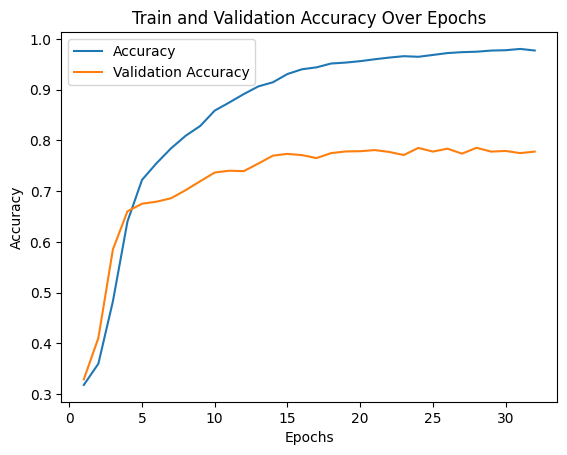

In [125]:
# Dapatkan nilai akurasi dari histori pelatihan
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Dapatkan nilai epochs yang sebenarnya (mungkin lebih kecil jika menggunakan EarlyStopping)
actual_epochs = len(train_accuracy)

# Plot akurasi pelatihan dan validasi
epochs_range = range(1, actual_epochs + 1)
plt.plot(epochs_range, train_accuracy, label='Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Train and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

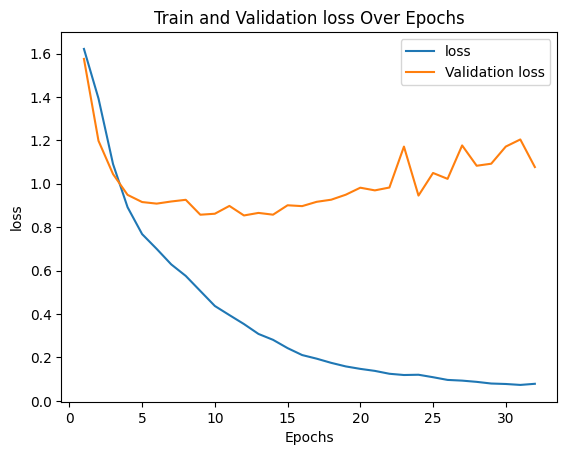

In [126]:
# Dapatkan nilai akurasi dari histori pelatihan
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Dapatkan nilai epochs yang sebenarnya (mungkin lebih kecil jika menggunakan EarlyStopping)
actual_epochs = len(train_accuracy)

# Plot akurasi pelatihan dan validasi
epochs_range = range(1, actual_epochs + 1)
plt.plot(epochs_range, train_accuracy, label='loss')
plt.plot(epochs_range, val_accuracy, label='Validation loss')
plt.title('Train and Validation loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()